In [187]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from itertools import count
from matplotlib import pyplot as plt
from copy import copy
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from openscm import timeframes

In [188]:
def plot_timeframe(ax, values, start_time, period_length, color=None, label=None):
    x = np.linspace(start_time, start_time + len(values) * period_length, len(values) + 1)
    ax.step(x, np.concatenate(([values[0]], values)), color=color, label=label)

# Input data

## Source timeframe

In [189]:
source_start_time = 0
source_period_length = 10

## Target timeframe

In [190]:
target_start_time = 4
target_period_length = 7

## Test values to convert

In [191]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])

Values are **averages** for their corresponding period

## Plot

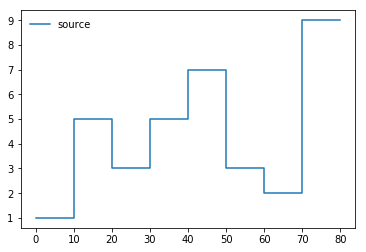

In [192]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source_start_time, source_period_length, label="source")
ax.legend(frameon=False);

# 1. Linearization

In a first step the data points are interpolated to gain the alleged "real" underlying data such that their average (i.e. integral over the period divided by the period length) equals the original source data. The linearization is based on three points per period. At each period edge the value is assumed to equal the average of the values for the two adjacent periods, at the period mid point the value is adjusted such that the period average equals the original period value. For the first and the last period the mid points are assumed to be at the period averade and the outer edges are adjusted accordingly.

In [193]:
linearization_points, linearization_values = timeframes._calc_linearization(source_values, source_start_time, source_period_length)

## Plot

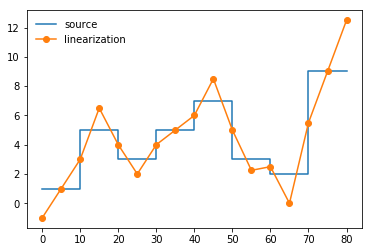

In [194]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source_start_time, source_period_length, label="source")
ax.plot(linearization_points, linearization_values, label="linearization", marker="o")
ax.legend(frameon=False);

# 2. Interpolation

In a second step, the linearization values are taken for their infelction points and the edges for the target timeframe.

In [195]:
interpolation_points, target_indices, first_interval_length, last_interval_length = timeframes._calc_interpolation_points(
    len(source_values),
    source_start_time,
    source_period_length,
    target_start_time,
    target_period_length,
)
interpolation_values = np.interp(
    interpolation_points, linearization_points, linearization_values
)

## Plot

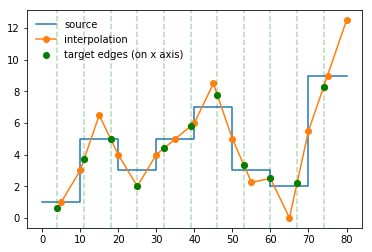

In [196]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source_start_time, source_period_length, label="source")
ax.plot(interpolation_points, interpolation_values, label="interpolation", marker="o")
ax.scatter(interpolation_points[target_indices], interpolation_values[target_indices], color="green", zorder=10, label="target edges (on x axis)")
for x in interpolation_points[target_indices]:
    ax.axvline(x=x, color="green", alpha=0.3, ls="--")
ax.legend(frameon=False);

# 3. Average over intervals

To gain the target timeframe values the averages of all points per target time period (i.e. the integral over the target time period divided by the period length) is taken. For the first and last period the average is taken only over the available data points.

In [197]:
interval_averages = timeframes._calc_interval_averages(
    interpolation_points,
    interpolation_values,
    target_indices,
    first_interval_length,
    target_period_length,
    last_interval_length,
)

## Plot

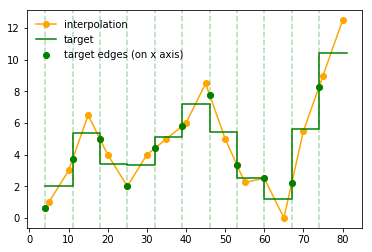

In [198]:
ax = plt.figure().add_subplot(111)
ax.plot(interpolation_points, interpolation_values, label="interpolation", marker="o", color="orange")
ax.scatter(interpolation_points[target_indices], interpolation_values[target_indices], color="green", zorder=10, label="target edges (on x axis)")
plot_timeframe(ax, interval_averages, target_start_time, target_period_length, label="target", color="green")
for x in interpolation_points[target_indices]:
    ax.axvline(x=x, color="green", alpha=0.3, ls="--")
ax.legend(frameon=False);

# Result

The `timeframes._convert` function is used by `timeframes.TimeframeConverter`, which is also responsible for caching, i.a., the interpolation points.

In [199]:
target_values = timeframes._convert(source_values, source_start_time, source_period_length, target_start_time, target_period_length)

## Plot

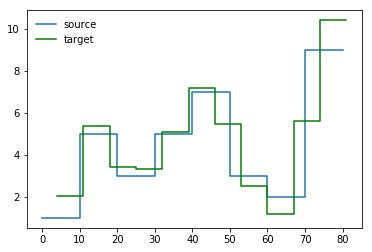

In [200]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source_start_time, source_period_length, label="source")
plot_timeframe(ax, target_values, target_start_time, target_period_length, label="target", color="green")
ax.legend(frameon=False);

# Converting back and forth

Depending on the target timeframe converting might lose some information and converting back and forth not necessarily leads to the original source (but converting to the same timeframe yields the same).

In [201]:
back_converted = timeframes._convert(target_values, target_start_time, target_period_length, source_start_time, source_period_length)

## Plot

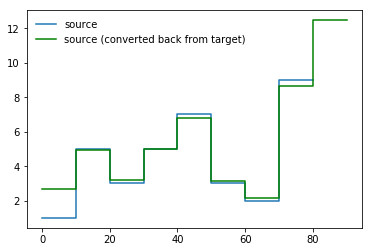

In [202]:
ax = plt.figure().add_subplot(111)
plot_timeframe(ax, source_values, source_start_time, source_period_length, label="source")
plot_timeframe(ax, back_converted, source_start_time, source_period_length, label="source (converted back from target)", color="green")
ax.legend(frameon=False);